## Import and libraries

In [1]:
#!pip install evaluate

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import evaluate
import plotly.express as px
from matplotlib import pyplot as plt
import keras
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import Dense, Dropout, Input, Convolution2D, BatchNormalization, Activation, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset

In [3]:
from datasets import load_dataset

gtzan = load_dataset("marsyas/gtzan", "all", trust_remote_code=True)
gtzan

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 999
    })
})

In [4]:
# Splitting data into training and validation
seed = 42
df = gtzan['train'].train_test_split(seed = seed, shuffle = True, test_size = .2)
df

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 799
    })
    test: Dataset({
        features: ['file', 'audio', 'genre'],
        num_rows: 200
    })
})

In [5]:
df['train']

Dataset({
    features: ['file', 'audio', 'genre'],
    num_rows: 799
})

In [6]:
temp = df['test'].train_test_split(seed = seed, shuffle = True, test_size = .5)
df['validation'] = temp['train']
df['test'] = temp['test']
print(df['validation'].shape, df['test'].shape)

(100, 3) (100, 3)


Split dataset into training (80%) and test set (20%)

### Inspect

In [7]:
id = 5
print("file:", df['train'][id]['file'])
print('\n')
print("audio: ", df['train'][id]['audio'])
print('\n')
print("genre:", df['train'][id]['genre'])
print('\n')

file: C:\Users\andre\.cache\huggingface\datasets\downloads\extracted\2d507dde7d1314fcf894cca246c17d29f6dcf0c0a636a83c7af4415239703e5c\genres\classical\classical.00020.wav


audio:  {'path': 'C:\\Users\\andre\\.cache\\huggingface\\datasets\\downloads\\extracted\\2d507dde7d1314fcf894cca246c17d29f6dcf0c0a636a83c7af4415239703e5c\\genres\\classical\\classical.00020.wav', 'array': array([-0.05187988, -0.06655884, -0.04104614, ...,  0.08074951,
        0.06646729,  0.04180908]), 'sampling_rate': 22050}


genre: 1




In [8]:
df['train'][id]['audio']['array']

array([-0.05187988, -0.06655884, -0.04104614, ...,  0.08074951,
        0.06646729,  0.04180908])

The following information are retrieved:
*   file = audio path
*   audio = represented by 1 dimensional array and relative sampling rate of 22,050 Hz
*   genre = family of song (integer)



In [9]:
id2label_function = df['train'].features['genre'].int2str

# Collect all unique genre IDs
unique_genre_ids = set([sample['genre'] for sample in df['train']])

# Create a mapping of genre IDs to labels
genre_mapping = {genre_id: id2label_function(genre_id) for genre_id in unique_genre_ids}

# Display the distinct genres with their IDs
print("Distinct Genres and their IDs:")
for genre_id, genre_label in sorted(genre_mapping.items()):
    print(f"ID: {genre_id}, Genre: {genre_label}")

Distinct Genres and their IDs:
ID: 0, Genre: blues
ID: 1, Genre: classical
ID: 2, Genre: country
ID: 3, Genre: disco
ID: 4, Genre: hiphop
ID: 5, Genre: jazz
ID: 6, Genre: metal
ID: 7, Genre: pop
ID: 8, Genre: reggae
ID: 9, Genre: rock


In [10]:
sampling_rate_check = None
all_same = True

# Iterating through each sample
for set_name in ['train', 'test']: # Iterating through both sets
    for sample in df[set_name]:
        sampling_rate = sample['audio']['sampling_rate']

        if sampling_rate_check is None:
            sampling_rate_check = sampling_rate
        else:
            if sampling_rate != sampling_rate_check:
                all_same = False
            break

# Printing result
if all_same:
    print(f"All samples have the same sampling rate: {sampling_rate_check} Hz")
else:
    print("The samples in the dataframe have different sampling rates.")

All samples have the same sampling rate: 22050 Hz


In [11]:
paper_color = '#f5f7f6'
bg_color = '#f5f7f6'
colormap = 'cividis'
labels = {} # Initializing empty list

# Defining a function to count labels
def count_genres(df):
    for sample in df:
        genre_label = id2label_function(sample['genre'])

        if genre_label in labels:
            labels[genre_label] += 1

        else:
            labels[genre_label] = 1

# Counting labels in both sets
count_genres(df['train'])
count_genres(df['validation'])
count_genres(df['test'])

# Obtaining genres and count values
genres = list(labels.keys())
counts = list(labels.values())

# Plotting bar plot
fig = px.bar(x = genres, y = counts, text = counts)
fig.update_traces(marker=dict(color="#4682B4"))
fig.update_layout(title = '<b>Genre Counts</b>', showlegend = True, height = 500, width = 750,
                 plot_bgcolor=bg_color,paper_bgcolor=paper_color)
fig.update_yaxes(title_text = '<b>Count</b>')
fig.update_xaxes(title = '<b>Genres</b>')

fig.show()

### Listen and display amplitude

In [12]:
for i in range(df['train'].shape[0]):
  print(i, id2label_function(df['train'][i]['genre']))

0 rock
1 disco
2 disco
3 country
4 jazz
5 classical
6 classical
7 blues
8 disco
9 disco
10 country
11 blues
12 disco
13 classical
14 reggae
15 blues
16 reggae
17 reggae
18 hiphop
19 classical
20 classical
21 rock
22 hiphop
23 disco
24 hiphop
25 country
26 jazz
27 blues
28 country
29 disco
30 reggae
31 disco
32 pop
33 country
34 jazz
35 reggae
36 pop
37 disco
38 disco
39 reggae
40 country
41 disco
42 rock
43 classical
44 country
45 disco
46 hiphop
47 metal
48 country
49 pop
50 hiphop
51 reggae
52 classical
53 metal
54 blues
55 jazz
56 metal
57 reggae
58 country
59 disco
60 classical
61 metal
62 rock
63 disco
64 metal
65 metal
66 jazz
67 reggae
68 pop
69 jazz
70 metal
71 jazz
72 hiphop
73 jazz
74 pop
75 blues
76 metal
77 classical
78 blues
79 pop
80 pop
81 jazz
82 jazz
83 jazz
84 rock
85 jazz
86 country
87 reggae
88 classical
89 blues
90 hiphop
91 blues
92 rock
93 rock
94 jazz
95 disco
96 metal
97 blues
98 disco
99 country
100 reggae
101 pop
102 classical
103 country
104 reggae
105 metal

ids:
*   id = 2 -> disco
*   id = 3 -> country
*   id = 4 -> jazz
*   id = 5 -> classical
*   id = 7 -> blues
*   id = 14 -> raggae
*   id = 18 -> hiphop
*   id = 42 -> rock
*   id = 32 -> pop
*   id = 212 -> metal



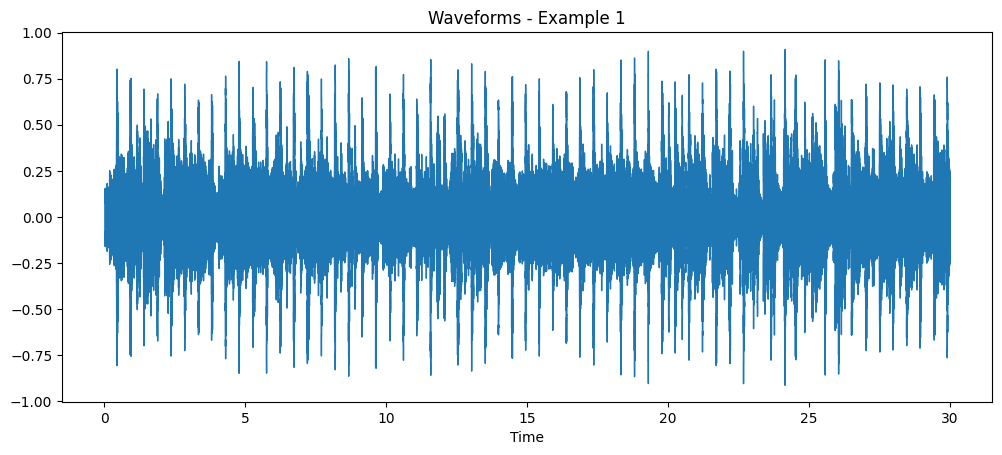

genre:  disco


In [13]:
id = 2
# Selecting array sound & sampling rate
array = df['train'][id]['audio']['array']
sampling_rate = df['train'][id]['audio']['sampling_rate']

# Plotting waveform with librosa
plt.figure().set_figwidth(12)
plt.title('Waveforms - Example 1')
librosa.display.waveshow(array, sr = sampling_rate)
plt.show()

# Printing genre
print("genre: ", id2label_function(df['train'][id]['genre']))

In [14]:
Audio(data = array, rate = sampling_rate)

## Fast Fourier Transformation

In [15]:
def compute_fft(audio_arrays, sampling_rate):
    """
    Calcola la FFT e le frequenze corrispondenti per ogni traccia audio.
    
    :param audio_arrays: Lista di array audio
    :param sampling_rate: Frequenza di campionamento
    :return: Tuple contenente la lista dei risultati FFT e la lista delle frequenze
    """
    fft_results = [np.fft.fft(audio) for audio in audio_arrays]
    freqs = [np.fft.fftfreq(len(audio), 1 / sampling_rate) for audio in audio_arrays]
    return fft_results, freqs

train = [df['train'][id]['audio']['array'] for id in range(len(df['train']))]
validation = [df['validation'][id]['audio']['array'] for id in range(len(df['validation']))]
test = [df['test'][id]['audio']['array'] for id in range(len(df['test']))]

fft_train, freqs_train = compute_fft(train, sampling_rate)
fft_validation, freqs_validation = compute_fft(validation, sampling_rate)
fft_test, freqs_test = compute_fft(test, sampling_rate)

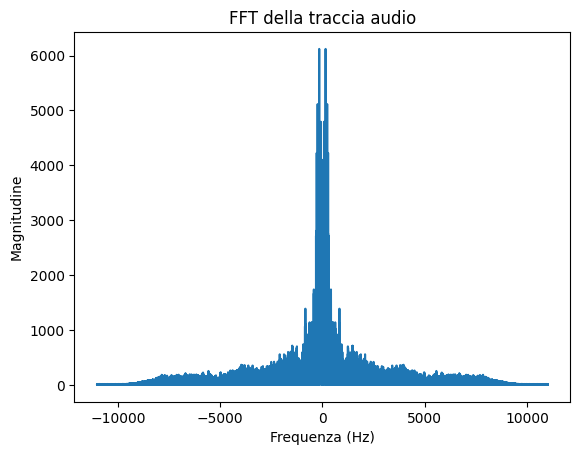

In [ ]:
plt.plot(freqs_validation[0], np.abs(fft_validation[0]))
plt.xlabel('Frequenza (Hz)')
plt.ylabel('Magnitudine')
plt.title('FFT della traccia audio')
plt.show()

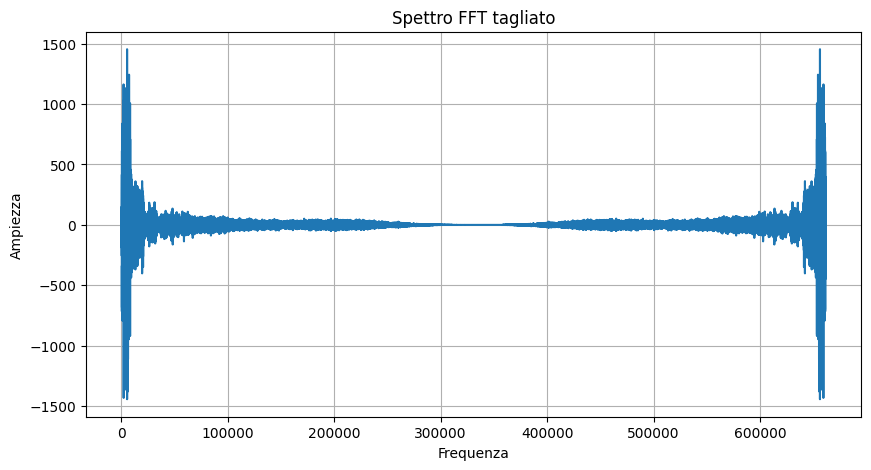

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(np.real(fft_train[0]))  # Sostituisci con un altro indice se necessario
plt.xlabel("Frequenza")
plt.ylabel("Ampiezza")
plt.title("Spettro FFT tagliato")
plt.grid()
plt.show()

In [ ]:
a = []
for el in fft_train:
    a.append(len(el))

min(a)

660000

In [ ]:
def cut_fourier(fft_result, max_freq=660000):
    """
    Taglia la FFT e le frequenze a max_freq
    """
    input = np.real(fft_result)
    output = input[:max_freq]
    return output

fft_train_cut = [cut_fourier(fft_result) for fft_result in fft_train]
fft_validation_cut = [cut_fourier(fft_result) for fft_result in fft_validation]
fft_test_cut = [cut_fourier(fft_result) for fft_result in fft_test]

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning:

Casting complex values to real discards the imaginary part

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning:

Casting complex values to real discards the imaginary part



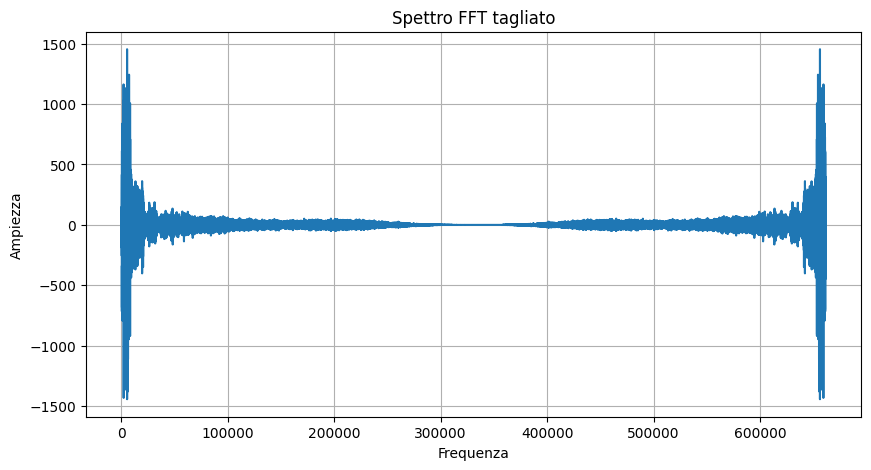

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(fft_train[0])  # Sostituisci con un altro indice se necessario
plt.xlabel("Frequenza")
plt.ylabel("Ampiezza")
plt.title("Spettro FFT tagliato")
plt.grid()
plt.show()

### FNN with Fourier

In [ ]:
ground_truth_train = [df['train'][id]['genre'] for id in range(len(df['train']))]
ground_truth_validation = [df['validation'][id]['genre'] for id in range(len(df['validation']))]
ground_truth_test = [df['test'][id]['genre'] for id in range(len(df['test']))]

In [ ]:
id2label_function = df['train'].features['genre'].int2str

# Trova tutti i generi unici nel dataset
unique_genre_ids = sorted(set(ground_truth_train + ground_truth_validation + ground_truth_test))
num_classes = len(unique_genre_ids)

# Mappatura ID -> Nome del genere
genre_mapping = {genre_id: id2label_function(genre_id) for genre_id in unique_genre_ids}
print("Mapping Generi:", genre_mapping)

# Normalizzazione delle FFT trasformate
scaler = StandardScaler()
X_train = scaler.fit_transform(np.array(fft_train_cut))
X_validation = scaler.transform(np.array(fft_validation_cut))
X_test = scaler.transform(np.array(fft_test_cut))

# Encoding delle etichette (da ID a one-hot)
y_train = to_categorical([unique_genre_ids.index(g) for g in ground_truth_train], num_classes=num_classes)
y_validation = to_categorical([unique_genre_ids.index(g) for g in ground_truth_validation], num_classes=num_classes)
y_test = to_categorical([unique_genre_ids.index(g) for g in ground_truth_test], num_classes=num_classes)

# Definizione della rete neurale
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Addestramento con validazione
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=10, batch_size=32)

Mapping Generi: {0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.1246 - loss: 10.2664 - val_accuracy: 0.1200 - val_loss: 4.5860
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.2489 - loss: 65.7209 - val_accuracy: 0.1600 - val_loss: 4.0137
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.3257 - loss: 53.3562 - val_accuracy: 0.1500 - val_loss: 4.3285
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.3680 - loss: 41.2600 - val_accuracy: 0.1600 - val_loss: 4.1042
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4047 - loss: 37.0551 - val_accuracy: 0.1700 - val_loss: 4.0855
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4755 - loss: 28.5055 - val_accuracy: 0.1800 - val_loss: 3.6714
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4804 - loss: 23.7119 - val_accuracy: 0.1900 - val_loss: 3.1340
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.4876 - loss: 27.9307 - val_accuracy: 0.1600 - v

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


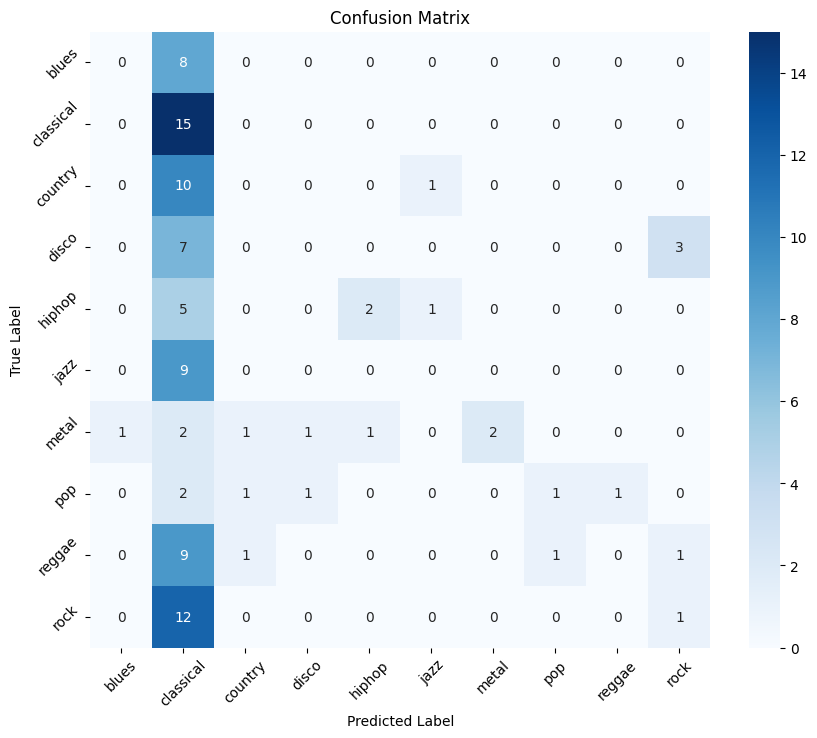


Classification Report:
              precision    recall  f1-score   support

       blues       0.00      0.00      0.00         8
   classical       0.19      1.00      0.32        15
     country       0.00      0.00      0.00        11
       disco       0.00      0.00      0.00        10
      hiphop       0.67      0.25      0.36         8
        jazz       0.00      0.00      0.00         9
       metal       1.00      0.25      0.40         8
         pop       0.50      0.17      0.25         6
      reggae       0.00      0.00      0.00        12
        rock       0.20      0.08      0.11        13

    accuracy                           0.21       100
   macro avg       0.26      0.17      0.14       100
weighted avg       0.22      0.21      0.14       100



In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converti one-hot in classi
y_test_classes = np.argmax(y_test, axis=1)  # Converti one-hot in classi

# Genera la confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Etichette dei generi per asse x/y
genre_labels = [genre_mapping[g] for g in unique_genre_ids]

# Plot della Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=genre_labels, yticklabels=genre_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Report di classificazione
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=genre_labels))


## MFCC

In [15]:
ground_truth_train = [df['train'][id]['genre'] for id in range(len(df['train']))]
ground_truth_validation = [df['validation'][id]['genre'] for id in range(len(df['validation']))]
ground_truth_test = [df['test'][id]['genre'] for id in range(len(df['test']))]

In [16]:
def compute_mfcc(audio_arrays, sampling_rate, n_mfcc=32):
    """
    Calcola gli MFCC per ogni traccia audio.
    
    :param audio_arrays: Lista di array audio
    :param sampling_rate: Frequenza di campionamento
    :param n_mfcc: Numero di coefficienti MFCC da estrarre (default 10)
    :return: Lista dei coefficienti MFCC per ogni traccia audio
    """
    mfcc_results = [librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=n_mfcc) for audio in audio_arrays]
    return mfcc_results

# Prepara gli array audio per il training, validazione e test
train = [df['train'][id]['audio']['array'] for id in range(len(df['train']))]
validation = [df['validation'][id]['audio']['array'] for id in range(len(df['validation']))]
test = [df['test'][id]['audio']['array'] for id in range(len(df['test']))]

# Calcola gli MFCC per i dati di addestramento, validazione e test
mfcc_train = compute_mfcc(train, sampling_rate)
mfcc_validation = compute_mfcc(validation, sampling_rate)
mfcc_test = compute_mfcc(test, sampling_rate)

# Puoi visualizzare la dimensione degli MFCC per confermare il risultato
print(f"MFCC Train shape: {[mfcc.shape for mfcc in mfcc_train]}")
print(f"MFCC Validation shape: {[mfcc.shape for mfcc in mfcc_validation]}")
print(f"MFCC Test shape: {[mfcc.shape for mfcc in mfcc_test]}")

MFCC Train shape: [(32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1307), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1314), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1308), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1305), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1293), (32, 1308), (32, 1308), (32, 1293), (32, 1293), (32, 1293), (32, 1296), (32, 1293), (32, 1293), (32, 1293), (32, 1293

In [17]:
def cut_mfcc(mfcc_results, target_n_frames=1024):
    """
    Taglia o fa il padding delle matrici MFCC per ottenere una dimensione fissa di (10, 1293) per ogni traccia audio.
    
    :param mfcc_results: Lista di matrici MFCC (una per ogni traccia audio)
    :param target_n_frames: Numero target di frame (default 1024)
    :return: Lista di matrici MFCC tagliate o con padding (shape: [target_n_mfcc, target_n_frames])
    """
    mfcc_cut_results = []
    
    for mfcc in mfcc_results:
        # Seleziona solo i primi 1293 frame
        mfcc = mfcc[:, :target_n_frames]
        
        # Se la matrice ha meno di 1293 frame, aggiungi padding con zeri
        if mfcc.shape[1] < target_n_frames:
            padding = np.zeros((mfcc.shape[0], target_n_frames - mfcc.shape[1]))
            mfcc = np.hstack([mfcc, padding])
        
        # Aggiungi la matrice MFCC tagliata alla lista dei risultati
        mfcc_cut_results.append(mfcc)
    
    return mfcc_cut_results

# Esegui il cut su tutte le tracce MFCC
mfcc_train_cut = cut_mfcc(mfcc_train)
mfcc_validation_cut = cut_mfcc(mfcc_validation)
mfcc_test_cut = cut_mfcc(mfcc_test)

# Verifica la forma degli MFCC tagliati
print(f"MFCC Train Cut shape: {[mfcc.shape for mfcc in mfcc_train_cut]}")
print(f"MFCC Validation Cut shape: {[mfcc.shape for mfcc in mfcc_validation_cut]}")
print(f"MFCC Test Cut shape: {[mfcc.shape for mfcc in mfcc_test_cut]}")

MFCC Train Cut shape: [(32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 1024), (32, 

In [18]:
X_train = np.array(mfcc_train_cut)  # Matrici MFCC per il training
X_validation = np.array(mfcc_validation_cut)  # Matrici MFCC per la validazione
X_test = np.array(mfcc_test_cut)  # Matrici MFCC per il test

y_train = np.array(ground_truth_train)  # Etichette del training
y_validation = np.array(ground_truth_validation)  # Etichette della validazione
y_test = np.array(ground_truth_test)  # Etichette del test

# Definisci il numero di classi
n_classes = len(np.unique(y_train))  # Numero di generi distinti

id2label_function = df['train'].features['genre'].int2str

# Trova tutti i generi unici nel dataset
unique_genre_ids = sorted(set(ground_truth_train + ground_truth_validation + ground_truth_test))
num_classes = len(unique_genre_ids)

# Mappatura ID -> Nome del genere
genre_mapping = {genre_id: id2label_function(genre_id) for genre_id in unique_genre_ids}

y_train = to_categorical([unique_genre_ids.index(g) for g in ground_truth_train], num_classes=num_classes)
y_validation = to_categorical([unique_genre_ids.index(g) for g in ground_truth_validation], num_classes=num_classes)
y_test = to_categorical([unique_genre_ids.index(g) for g in ground_truth_test], num_classes=num_classes)

# Definizione della rete neurale
model = Sequential([
    Input(shape=(32,1024,1)),
    Convolution2D(32, (4,8), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D(),

    Convolution2D(64, (4,8), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D(),

    Convolution2D(128, (4,8), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D(),

    Flatten(),
    Dense(64),
    Dropout(0.4),
    BatchNormalization(),
    Activation("relu"),
    Dense(n_classes, activation=softmax)
])

# Compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='weights/mfcc_mod1.weights.h5',
    monitor='val_accuracy',
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    checkpoint_callback
]

# Addestramento con validazione
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=15, batch_size=32, callbacks=callbacks)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1643 - loss: 2.3856
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to weights/mfcc_mod1.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.1656 - loss: 2.3801 - val_accuracy: 0.2500 - val_loss: 6.8147 - learning_rate: 0.0010
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3252 - loss: 1.8794
Epoch 2: val_accuracy improved from 0.25000 to 0.29000, saving model to weights/mfcc_mod1.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.3260 - loss: 1.8767 - val_accuracy: 0.2900 - val_loss: 3.5061 - learning_rate: 0.0010
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4366 - loss: 1.5777
Epoch 3: val_accuracy did not improve from 0.29000
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4376 - loss: 1.5768 - val_accuracy: 0.2700 - val_loss: 2.8269 - learning_rate: 0.0010
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5684 - loss: 1.3436
E

In [19]:
X_train = np.array(mfcc_train_cut)  # Matrici MFCC per il training
X_validation = np.array(mfcc_validation_cut)  # Matrici MFCC per la validazione
X_test = np.array(mfcc_test_cut)  # Matrici MFCC per il test

y_train = np.array(ground_truth_train)  # Etichette del training
y_validation = np.array(ground_truth_validation)  # Etichette della validazione
y_test = np.array(ground_truth_test)  # Etichette del test

# Definisci il numero di classi
n_classes = len(np.unique(y_train))  # Numero di generi distinti

id2label_function = df['train'].features['genre'].int2str

# Trova tutti i generi unici nel dataset
unique_genre_ids = sorted(set(ground_truth_train + ground_truth_validation + ground_truth_test))
num_classes = len(unique_genre_ids)

# Mappatura ID -> Nome del genere
genre_mapping = {genre_id: id2label_function(genre_id) for genre_id in unique_genre_ids}

y_train = to_categorical([unique_genre_ids.index(g) for g in ground_truth_train], num_classes=num_classes)
y_validation = to_categorical([unique_genre_ids.index(g) for g in ground_truth_validation], num_classes=num_classes)
y_test = to_categorical([unique_genre_ids.index(g) for g in ground_truth_test], num_classes=num_classes)

# Definizione della rete neurale
model = Sequential([
    Input(shape=(32,1024,1)),
    Convolution2D(32, (4,8), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D(),

    Convolution2D(64, (4,8), padding="same"),
    BatchNormalization(),
    Activation("relu"),
    MaxPool2D(),

    Flatten(),
    Dense(64),
    Dropout(0.4),
    BatchNormalization(),
    Activation("relu"),
    Dense(n_classes, activation=softmax)
])

# Compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath='weights/mfcc_mod2.weights.h5',
    monitor='val_accuracy',
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    checkpoint_callback
]

# Addestramento con validazione
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=15, batch_size=32, callbacks=callbacks)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.1881 - loss: 2.2597
Epoch 1: val_accuracy improved from -inf to 0.19000, saving model to weights/mfcc_mod2.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 868ms/step - accuracy: 0.1890 - loss: 2.2554 - val_accuracy: 0.1900 - val_loss: 6.1286 - learning_rate: 0.0010
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.3758 - loss: 1.7271
Epoch 2: val_accuracy improved from 0.19000 to 0.40000, saving model to weights/mfcc_mod2.weights.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 853ms/step - accuracy: 0.3763 - loss: 1.7254 - val_accuracy: 0.4000 - val_loss: 2.4823 - learning_rate: 0.0010
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.5168 - loss: 1.4137
Epoch 3: val_accuracy did not improve from 0.40000
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 855ms/step - accuracy: 0.5169 - loss: 1.4133 - val_accuracy: 0.3800 - val_loss: 2.0736 - learning_rate: 0.0010
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 824ms/step - accuracy: 0.

In [24]:
model.load_weights('weights/mfcc_mod1.weights.h5')  
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Converti one-hot in classi
y_test_classes = np.argmax(y_test, axis=1)  # Converti one-hot in classi

# Genera la confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Etichette dei generi per asse x/y
genre_labels = [genre_mapping[g] for g in unique_genre_ids]

# Plot della Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=genre_labels, yticklabels=genre_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Report di classificazione
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=genre_labels))

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 30 variables whereas the saved optimizer has 38 variables. 



ValueError: A total of 2 objects could not be loaded. Example error message for object <Dense name=dense_2, built=True>:

The shape of the target variable and the shape of the target value in `variable.assign(value)` must match. variable.shape=(131072, 64), Received: value.shape=(65536, 64). Target variable: <Variable path=sequential_1/dense_2/kernel, shape=(131072, 64), dtype=float32, value=[[-0.00626498  0.03475628  0.00870748 ... -0.0021996  -0.00525088
   0.00523389]
 [ 0.00059642  0.01041572 -0.01077008 ... -0.00222475  0.00572453
   0.00033532]
 [-0.00546413  0.01526521  0.00713784 ... -0.00232675 -0.01258506
   0.00885118]
 ...
 [ 0.01141933  0.00241785 -0.00748281 ...  0.00870027 -0.00142252
  -0.00956357]
 [ 0.04983307  0.01184865 -0.00737217 ... -0.00579496  0.00451229
  -0.0079577 ]
 [ 0.01553255 -0.00589554 -0.00827997 ... -0.00124715 -0.00197804
  -0.002107  ]]>

List of objects that could not be loaded:
[<Dense name=dense_2, built=True>, <BatchNormalization name=batch_normalization_6, built=True>]

## Pre processing Hubert

In [23]:
# Loading model
model = "ntu-spml/distilhubert"

# Instantiating feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(model, do_normalize = True, return_attention_mask = True)

In [24]:
# Checking sampling rate
sampling_rate = feature_extractor.sampling_rate
print(f'DistilHuBERT Sampling Rate: {sampling_rate} Hz')

DistilHuBERT Sampling Rate: 16000 Hz


In [25]:
from datasets import Audio

# Resampling data
df = df.cast_column("audio", Audio(sampling_rate = 16000))

In [26]:
# Checking new sampling rate
print('\n* * * Dataset After Resampling* * *')
print('\n' * 3)
print("file:", df['train'][2]['file'])
print('\n')
print("audio: ", df['train'][2]['audio'])
print('\n')
print("genre:", df['train'][2]['genre'])
print('\n')


* * * Dataset After Resampling* * *




file: /root/.cache/huggingface/datasets/downloads/extracted/3b204381d6c029312e4f9c569c6b1130af3041dd36ca38ca53d4e20f585e39c6/genres/disco/disco.00088.wav


audio:  {'path': '/root/.cache/huggingface/datasets/downloads/extracted/3b204381d6c029312e4f9c569c6b1130af3041dd36ca38ca53d4e20f585e39c6/genres/disco/disco.00088.wav', 'array': array([ 0.03352892,  0.05795968,  0.09609947, ..., -0.03805662,
        0.00101842,  0.01898582]), 'sampling_rate': 16000}


genre: 3




In [27]:
# Computing mean and variance
sample = df['train'][9]['audio']

print('\nExample Data:\n')
print(f" Mean: {np.mean(sample['array']):.3}\n")
print(f" Variance: {np.var(sample['array']):.3}\n")


Example Data:

 Mean: -2.12e-05

 Variance: 0.0301



In [28]:
# Normalizing audio data
inputs = feature_extractor(sample['array'], sampling_rate = sample['sampling_rate'])

print(f"\nInputs Keys: {list(inputs.keys())}\n")

print(
    f" Mean: {np.mean(inputs['input_values']):.3}, Variance: {np.var(inputs['input_values']):.3}"
)


Inputs Keys: ['input_values', 'attention_mask']

 Mean: 1.15e-09, Variance: 1.0


In [29]:
# Defining audio maximum duration
max_duration = 30.0 # 30 seconds

def preprocess_function(examples):
    # Extracting and saving arrays
    audio_arrays = [x['array'] for x in examples['audio']]

    # Preprocessing audio inputs
    inputs = feature_extractor(audio_arrays,
                              sampling_rate = feature_extractor.sampling_rate,
                              max_length = int(feature_extractor.sampling_rate * max_duration),
                              truncation = True,
                              return_attention_mask = True)

    return inputs

In [30]:
# Preprocessing data
df = df.map(preprocess_function,
                   remove_columns = ['audio', 'file'],
                   batched = True,
                   batch_size = 100,
                   num_proc = 1)

df

Map:   0%|          | 0/799 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['genre', 'input_values', 'attention_mask'],
        num_rows: 799
    })
    test: Dataset({
        features: ['genre', 'input_values', 'attention_mask'],
        num_rows: 200
    })
})

In [31]:
# Renaming genre column
df = df.rename_column('genre', 'label')

In [32]:
# Id to label
id2label = {str(i): id2label_function(i)
           for i in range(len(df['train'].features['label'].names))}

# Label to id
label2id = {v: k for k, v in id2label.items()}

In [33]:
integer = 7 # Defining a random int
label = id2label[str(integer)] # Obtaining label

print(f'\nId: {integer}')
print(f'\nLabel: {label}')


Id: 7

Label: pop


## Classification Hubert

In [ ]:
num_labels = len(id2label) # Obtaining the total number of labels

# Loading model
hubert_model = AutoModelForAudioClassification.from_pretrained(model,
                                                         num_labels = num_labels,
                                                         label2id=label2id,
                                                         id2label=id2label)

config.json:   0%|          | 0.00/1.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/94.0M [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at ntu-spml/distilhubert and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Visualizing model's architecture
print('\nHuBERT Architecture')
print(hubert_model)


HuBERT Architecture
HubertForSequenceClassification(
  (hubert): HubertModel(
    (feature_extractor): HubertFeatureEncoder(
      (conv_layers): ModuleList(
        (0): HubertGroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x HubertNoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): HubertFeatureProjection(
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): HubertEncoder(
      (pos_conv_embed): HubertPos

In [ ]:
# Setting training arguments
training_args = TrainingArguments(
    output_dir = 'hubert_gtzan',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    load_best_model_at_end = True,
    metric_for_best_model = 'accuracy',
    learning_rate = 5e-5,
    seed = seed,
    per_device_train_batch_size = 8,
    per_device_eval_batch_size = 8,
    gradient_accumulation_steps = 1,
    num_train_epochs = 8,
    warmup_ratio = 0.1,
    fp16 = True,
    save_total_limit = 2,
    report_to = 'none'
    )

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning:

`evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead



In [ ]:
# Loading `accuracy` metric from the evaluate library
metric = evaluate.load('accuracy')
# Creating function to compute accuracy
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis = 1)
    return metric.compute(predictions = predictions, references = eval_pred.label_ids)

In [ ]:
# Setting trainer
trainer = Trainer(
    model=hubert_model,
    args = training_args,
    train_dataset = df['train'],
    eval_dataset = df['test'],
    tokenizer = feature_extractor,
    compute_metrics = compute_metrics)

<ipython-input-27-111942fc0319>:2: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



In [ ]:
# Training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.045444,0.385000


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.045444,0.385000
2,No log,1.427539,0.575000
3,No log,1.198686,0.615000
4,No log,0.977071,0.685000
5,1.337600,0.918943,0.695000
6,1.337600,0.805528,0.755000
7,1.337600,0.836702,0.750000
8,1.337600,0.844611,0.745000


KeyboardInterrupt: 

In [ ]:
# Saving model & feature extractor
directory = 'fine_tuned_hubert'
trainer.save_model(directory)
feature_extractor.save_pretrained(directory)